In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from PIL import Image
from collections import defaultdict

In [2]:
class SeamCarvingDAG:
    """
    représentation explicite du graphe orienté acyclique (DAG) pour le seam carving
    chaque pixel de l'image est représenté par un noeud du graphe
    chaque noeud est connecté aux trois pixels situés directement en dessous (down-left, down et down-right)
    le poids d'une arête correspond à l'énergie du pixel de destination
    """

    def __init__(self, energy_map):
        self.energy = energy_map
        self.height, self.width = energy_map.shape #dimensions de l’image
        self.V = self.height * self.width #nbr total de noeuds = nbr de pixels
        self.graph = defaultdict(list) #adjacency list du DAG
        self._build_graph() #construction du graphe

    def _pixel_to_node(self, x, y): #convertit les coordonnées (x, y) d’un pixel en un identifiant unique de noeud
        return y * self.width + x

    def _node_to_pixel(self, node_id): #convertit un identifiant de noeud en coordonnées (x, y) dans l’image
        y = node_id // self.width
        x = node_id % self.width
        return x, y

    def _build_graph(self):
        """
        pour construire le graphe DAG
        chaque pixel (x, y) est connecté aux pixels (si ces pixels existent dans l'image)
        (x-1, y+1)
        (x, y+1)
        (x+1, y+1)
        """
        for y in range(self.height - 1):
            for x in range(self.width):
                u = self._pixel_to_node(x, y)

                #détermination des voisins accessibles (connexions)
                connections = []
                if x > 0:
                    connections.append((x - 1, y + 1)) #en bas à gauche
                connections.append((x, y + 1)) #en bas
                if x < self.width - 1:
                    connections.append((x + 1, y + 1)) #en bas à droite

                #ajout des arêtes vers les voisins
                for next_x, next_y in connections:
                    v = self._pixel_to_node(next_x, next_y)
                    weight = self.energy[next_y, next_x] #poids de l’arête = énergie du pixel destination
                    self.graph[u].append((v, weight))

    def topologicalSortUtil(self, v, visited, stack):
        """
        fonction de tri topologique d'un DAG par DFS (tel que donné dans le tutoriel du cours Shortest & Longest Paths on DAGs)
        """
        visited[v] = True
        #parcours des successeurs
        if v in self.graph:
            for node, weight in self.graph[v]:
                if not visited[node]:
                    self.topologicalSortUtil(node, visited, stack)

        #ajout du nœud à la pile une fois exploré
        stack.append(v)

    def find_shortest_path_from_top(self):
        """
        (inspirée de la fonction find_paths du tutoriel du cours Shortest & Longest Paths on DAGs)
        calcule le chemin de coût minimal entre la première ligne et la dernière ligne de l'image (seam vertical)
        en output :
        seam : liste des positions x du seam pour chaque ligne
        M : matrice des coûts cumulés
        dist : distances minimales pour tous les nœuds
        """

        #initialisation
        visited = [False] * self.V
        stack = []

        #tri topologique du DAG
        for i in range(self.V):
            if not visited[i]:
                self.topologicalSortUtil(i, visited, stack)

        #initialisation des distances
        dist = [float('Inf')] * self.V
        parent = [-1] * self.V

        #les pixels de la première ligne sont les sources
        for x in range(self.width):
            source_node = self._pixel_to_node(x, 0)
            dist[source_node] = self.energy[0, x]

        #relaxation des arêtes (shortest path sur DAG)
        while stack:
            u = stack.pop()

            if dist[u] != float('Inf'):
                for v, weight in self.graph[u]:
                    if dist[v] > dist[u] + weight:
                        dist[v] = dist[u] + weight
                        parent[v] = u

        #backtracking pour extraire le seam optimal
        min_dist = float('Inf')
        end_node = -1

        #recherche du nœud de coût minimal sur la dernière ligne
        for x in range(self.width):
            node = self._pixel_to_node(x, self.height - 1)
            if dist[node] < min_dist:
                min_dist = dist[node]
                end_node = node

        #reconstruction du seam en remontant les parents
        seam = []
        current = end_node
        while current != -1:
            x, y = self._node_to_pixel(current)
            seam.append(x)
            current = parent[current]
        seam.reverse()

        #construction de la matrice M des coûts cumulés
        M = np.full((self.height, self.width), float('Inf'))
        for node_id, d in enumerate(dist):
            x, y = self._node_to_pixel(node_id)
            M[y, x] = d

        return seam, M, dist


In [3]:
def calculate_energy_map(image):
    """
    calcule l'energy map de l'image à l'aide du gradient de Sobel
    les pixels avec de fortes variations d'intensité (bords, contours, textures) auront une énergie élevée, tandis que les zones uniformes auront une faible énergie
    """
    #si l’image est en couleur (RGB), on la convertit en niveaux de gris en moyennant les trois canaux
    if len(image.shape) == 3:
        gray = np.mean(image, axis=2)
    else:
        gray = image

    #calcul du gradient horizontal (variation selon x)
    gradient_x = sobel(gray, axis=1)

    #calcul du gradient vertical (variation selon y)
    gradient_y = sobel(gray, axis=0)

    #magnitude du gradient en norme euclidienne (cette valeur représente l’énergie du pixel)
    energy = np.sqrt(gradient_x**2 + gradient_y**2)

    return energy


In [4]:
def remove_seam(image, seam):
    """
    supprime un seam vertical de l'image
    en paramètres :
    image : image originale
    seam  : liste contenant, pour chaque ligne y, la position x du pixel à supprimer
    """

    #dimensions de l’image originale
    height, width = image.shape[:2]

    #pour une image couleur (RGB)
    new_image = np.zeros((height, width-1, image.shape[2]),dtype=image.dtype)

    #suppression du pixel du seam ligne par ligne
    for y in range(height):
        x_seam = seam[y]

        #copier les pixels à gauche du seam
        new_image[y, :x_seam] = image[y, :x_seam]

        #copier les pixels à droite du seam (on saute le pixel du seam)
        new_image[y, x_seam:] = image[y, x_seam + 1:]

    return new_image



In [5]:
def seam_carving(image, num_seams):
    """
    applique l'algorithme de seam carving pour supprimer num_seams seams verticaux
    à chaque itération la fonction :
    calcule l'energy map de l'image courante
    construit le graphe DAG associé
    recherche le seam d'énergie minimale (shortest path)
    supprime ce seam
    """

    all_seams = [] #stocke tous les seams extraits
    current_image = np.copy(image) #image mise à jour après chaque suppression

    #boucle principale : suppression itérative des seams
    for i in range(num_seams):
        print(f"\nseam numéro : {i+1}/{num_seams}")

        #calcul de l'energy map
        energy = calculate_energy_map(current_image)

        #construction du DAG
        dag = SeamCarvingDAG(energy)

        #recherche du seam optimal via shortest path dans un DAG
        seam, M, dist = dag.find_shortest_path_from_top()

        #affichage de l’énergie totale du seam extrait
        print(f"énergie: {M[-1, seam[-1]]:.2f}")

        #sauvegarder le seam trouvé
        all_seams.append(seam)

        #suppression du seam de l’image
        current_image = remove_seam(current_image, seam)

    #retourner l’image finale et l’ensemble des seams extraits
    return current_image, all_seams


In [6]:
#charger l'image
img_pil = Image.open('tunisia.jpg')
test_image = np.array(img_pil)
print(f"image chargée: {test_image.shape[1]} × {test_image.shape[0]} pixels")

image chargée: 1200 × 675 pixels


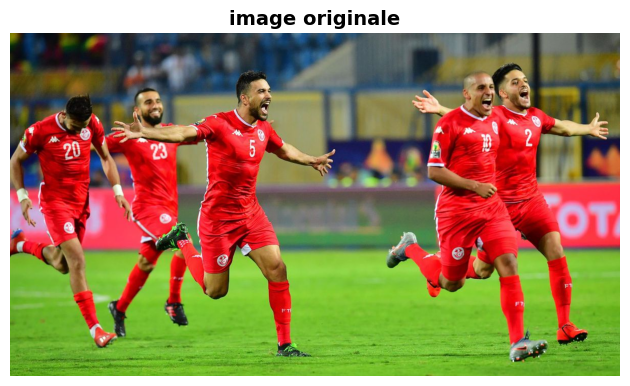

In [7]:
plt.imshow(test_image)
plt.title("image originale", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

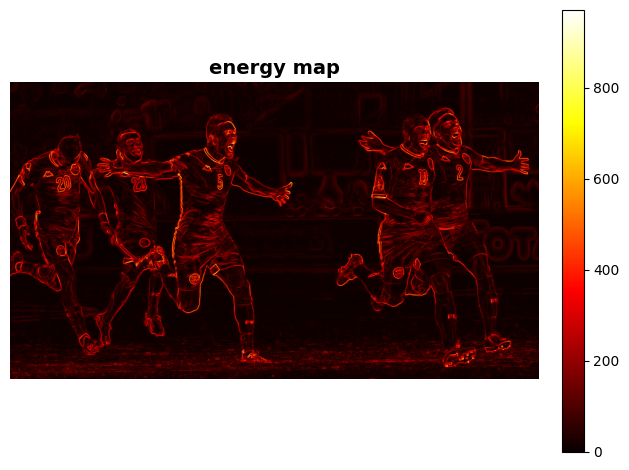

In [8]:
energy = calculate_energy_map(test_image)
im = plt.imshow(energy, cmap='hot')
plt.title("energy map", fontsize=14, fontweight='bold')
plt.axis('off')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

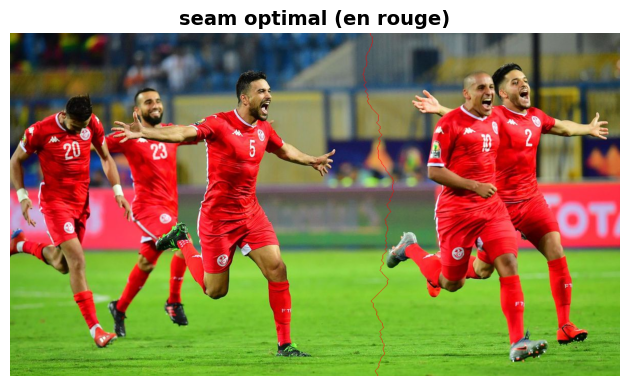

In [9]:
dag = SeamCarvingDAG(energy)
seam, M, dist = dag.find_shortest_path_from_top()

img_with_seam = np.copy(test_image)
for y, x in enumerate(seam):
    img_with_seam[y, x] = [255, 0, 0]  #rouge

plt.imshow(img_with_seam, cmap='gray')
plt.title("seam optimal (en rouge)", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


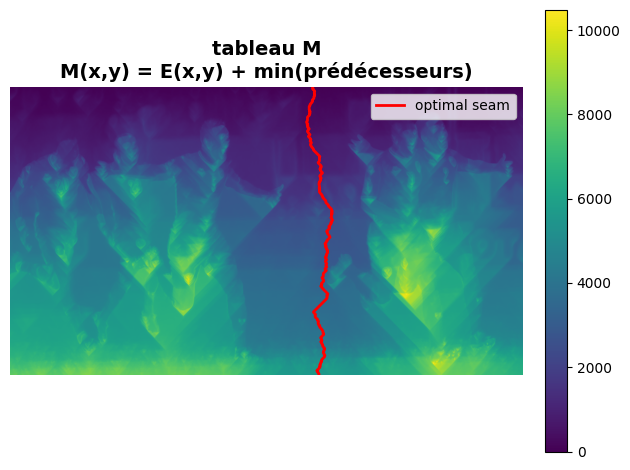

In [10]:
M_vis = M.copy()
M_vis[M_vis == float('Inf')] = np.nan

im = plt.imshow(M_vis, cmap='viridis')
plt.plot(seam, range(len(seam)), 'r-', linewidth=2, label='optimal seam')
plt.title("tableau M\nM(x,y) = E(x,y) + min(prédécesseurs)", 
          fontsize=14, fontweight='bold')
plt.legend()
plt.axis('off')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


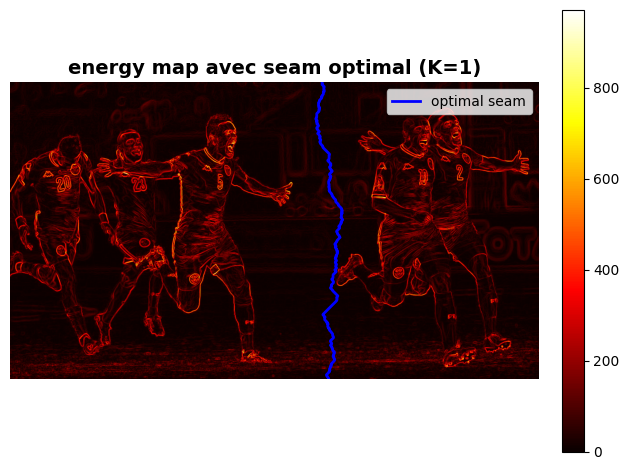

In [11]:
im = plt.imshow(energy, cmap='hot')
plt.plot(seam, range(len(seam)), 'b-', linewidth=2, label='optimal seam')
plt.title(f"energy map avec seam optimal (K=1)", fontsize=14, fontweight='bold')
plt.legend()
plt.axis('off')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


région centrée sur le seam: lignes 332-342, colonnes 737-747
position du seam au centre: x=742, y=337


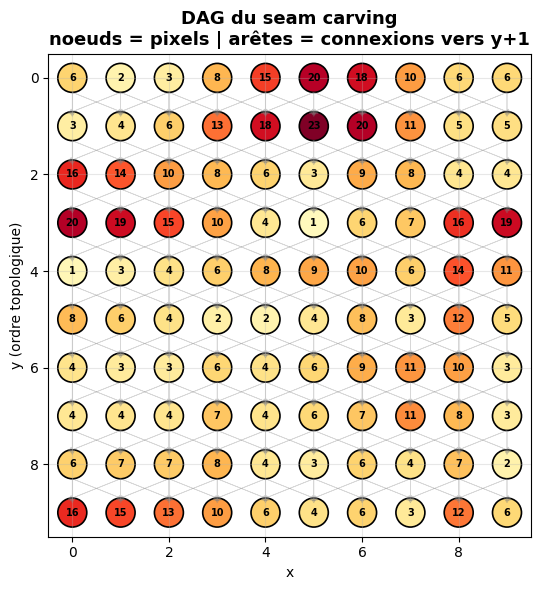

In [12]:
#région à visualiser (pour lisibilité)
max_rows, max_cols = 10,10
vis_height = min(max_rows, energy.shape[0])
vis_width = min(max_cols, energy.shape[1])

#calculer d'abord le seam
dag_for_viz = SeamCarvingDAG(energy)
seam, M, dist = dag_for_viz.find_shortest_path_from_top()

#centrer la visualisation sur le seam (milieu de l'image)
mid_y = len(seam) // 2
mid_x = seam[mid_y]

start_y = max(0, min(mid_y - vis_height // 2, energy.shape[0] - vis_height))
start_x = max(0, min(mid_x - vis_width // 2, energy.shape[1] - vis_width))

energy_subset = energy[start_y:start_y + vis_height, start_x:start_x + vis_width]
M_subset = M[start_y:start_y + vis_height, start_x:start_x + vis_width]

print(f"région centrée sur le seam: lignes {start_y}-{start_y+vis_height}, colonnes {start_x}-{start_x+vis_width}")
print(f"position du seam au centre: x={mid_x}, y={mid_y}")
plt.figure(figsize=(8, 6))
ax = plt.gca()

#pixels
for y in range(vis_height):
    for x in range(vis_width):
        color = plt.cm.YlOrRd(energy_subset[y, x] / energy_subset.max())
        circle = plt.Circle((x, y), 0.3, color=color, ec='black', linewidth=1.2)
        ax.add_patch(circle)
        ax.text(x, y, f'{energy_subset[y, x]:.0f}',
                ha='center', va='center', fontsize=7, fontweight='bold')

#connexions DAG
for y in range(vis_height - 1):
    for x in range(vis_width):
        for next_x in [x-1, x, x+1]:
            if 0 <= next_x < vis_width:
                ax.arrow(x, y + 0.3, next_x - x, 0.4,
                         head_width=0.12, head_length=0.1,
                         fc='gray', ec='gray', alpha=0.3, linewidth=0.5)

ax.set_xlim(-0.5, vis_width - 0.5)
ax.set_ylim(vis_height - 0.5, -0.5)
ax.set_aspect('equal')
ax.set_title("DAG du seam carving\nnoeuds = pixels | arêtes = connexions vers y+1",
             fontsize=13, fontweight='bold')
ax.set_xlabel("x")
ax.set_ylabel("y (ordre topologique)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


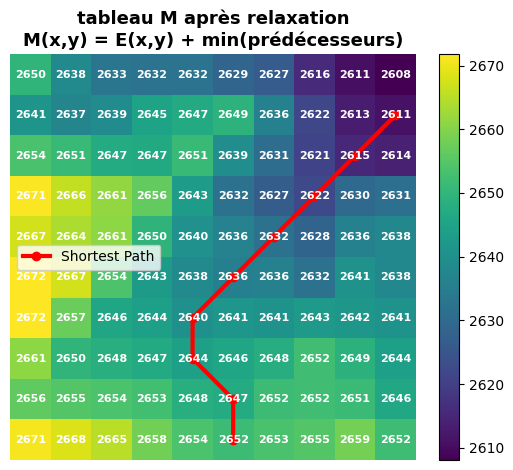

In [13]:
M_subset = M[start_y:start_y + vis_height, start_x:start_x + vis_width]
M_vis = M_subset.copy()
M_vis[M_vis == float('Inf')] = np.nan

im = plt.imshow(M_vis, cmap='viridis')

#affichage des valeurs
for y in range(vis_height):
    for x in range(vis_width):
        val = M_subset[y, x]
        if val != float('Inf'):
            color = 'white' if val > np.nanmax(M_vis) * 0.5 else 'black'
            plt.text(x, y, f'{val:.0f}',
                     ha='center', va='center',
                     fontsize=8, fontweight='bold', color=color)

#seam dans la fenêtre
seam_in_view = [(seam[y] - start_x, y - start_y)
                for y in range(len(seam))
                if start_y <= y < start_y + vis_height
                and start_x <= seam[y] < start_x + vis_width]

if seam_in_view:
    xs, ys = zip(*seam_in_view)
    plt.plot(xs, ys, 'r-', linewidth=3, marker='o', label='Shortest Path')
    plt.legend()


plt.xlabel("x")
plt.ylabel("y")
plt.title("tableau M après relaxation\nM(x,y) = E(x,y) + min(prédécesseurs)",
          fontsize=13, fontweight='bold')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.axis('off')
plt.tight_layout()
plt.show()


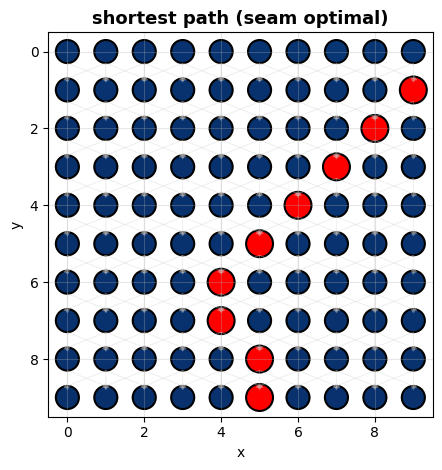

In [14]:
ax = plt.gca()

for y in range(vis_height):
    for x in range(vis_width):
        is_seam = (x + start_x, y + start_y) in [(seam[sy], sy) for sy in range(len(seam))]
        val = M_subset[y, x]

        if is_seam:
            color = 'red'
            radius = 0.35
        else:
            color = plt.cm.Blues(val / np.nanmax(M_vis)) if val != float('Inf') else 'lightgray'
            radius = 0.3

        circle = plt.Circle((x, y), radius, color=color, ec='black', linewidth=1.5)
        ax.add_patch(circle)

# Arêtes
for y in range(vis_height - 1):
    for x in range(vis_width):
        for next_x in [x-1, x, x+1]:
            if 0 <= next_x < vis_width:
                ax.arrow(x, y + 0.3, next_x - x, 0.4,
                         head_width=0.12, head_length=0.1,
                         fc='lightgray', ec='lightgray', alpha=0.3, linewidth=0.5)

ax.set_xlim(-0.5, vis_width - 0.5)
ax.set_ylim(vis_height - 0.5, -0.5)
ax.set_aspect('equal')
ax.set_title("shortest path (seam optimal)", fontsize=13, fontweight='bold')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [15]:
K = 30  # nbr de seams à retirer

temp_image = np.copy(test_image)
all_seams = []

for i in range(K):
    energy_temp = calculate_energy_map(temp_image)
    dag_temp = SeamCarvingDAG(energy_temp)
    seam_temp, _, _ = dag_temp.find_shortest_path_from_top()
    all_seams.append(seam_temp)
    temp_image = remove_seam(temp_image, seam_temp)
    
    print(f"{i + 1}/{K} seams calculés")


1/30 seams calculés
2/30 seams calculés
3/30 seams calculés
4/30 seams calculés
5/30 seams calculés
6/30 seams calculés
7/30 seams calculés
8/30 seams calculés
9/30 seams calculés
10/30 seams calculés
11/30 seams calculés
12/30 seams calculés
13/30 seams calculés
14/30 seams calculés
15/30 seams calculés
16/30 seams calculés
17/30 seams calculés
18/30 seams calculés
19/30 seams calculés
20/30 seams calculés
21/30 seams calculés
22/30 seams calculés
23/30 seams calculés
24/30 seams calculés
25/30 seams calculés
26/30 seams calculés
27/30 seams calculés
28/30 seams calculés
29/30 seams calculés
30/30 seams calculés


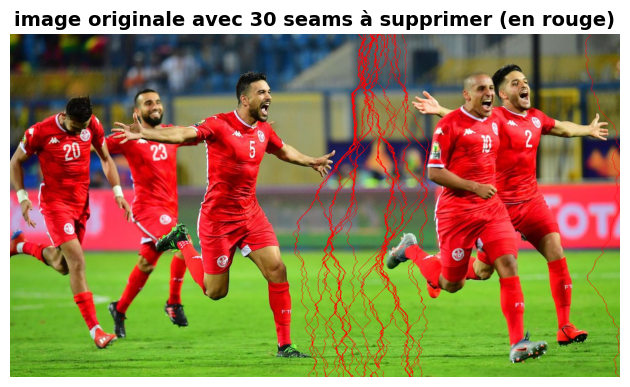

In [16]:
img_with_seams = np.copy(test_image).astype(float)

#pour chaque seam, on doit ajuster les coordonnées x en fonction de tous les seams précédents qui ont été retirés
for seam_idx, seam in enumerate(all_seams):
    for y, x in enumerate(seam):
        #calculer la position réelle dans l'image originale en comptant combien de seams précédents passent à gauche de x
        real_x = x
        
        #pour chaque seam précédent
        for prev_idx in range(seam_idx):
            prev_seam = all_seams[prev_idx]
            #si le seam précédent passe à gauche ou sur cette position à cette ligne y, alors on décale vers la droite
            if prev_seam[y] <= real_x:
                real_x += 1
        
        #marquer le pixel dans l'image originale
        if real_x < img_with_seams.shape[1]:
            if len(test_image.shape) == 3:
                img_with_seams[y, real_x] = [255, 0, 0]
            else:
                img_with_seams[y, real_x] = 255

plt.imshow(img_with_seams.astype(np.uint8), cmap='gray')
plt.title(f'image originale avec {len(all_seams)} seams à supprimer (en rouge)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
final_image, seams = seam_carving(test_image, K)


seam numéro : 1/30
énergie: 5561.76

seam numéro : 2/30
énergie: 5736.49

seam numéro : 3/30
énergie: 5751.94

seam numéro : 4/30
énergie: 5925.02

seam numéro : 5/30
énergie: 5987.93

seam numéro : 6/30
énergie: 6031.74

seam numéro : 7/30
énergie: 6099.50

seam numéro : 8/30
énergie: 6105.89

seam numéro : 9/30
énergie: 6162.58

seam numéro : 10/30
énergie: 6244.49

seam numéro : 11/30
énergie: 6270.19

seam numéro : 12/30
énergie: 6332.35

seam numéro : 13/30
énergie: 6389.34

seam numéro : 14/30
énergie: 6406.85

seam numéro : 15/30
énergie: 6417.09

seam numéro : 16/30
énergie: 6482.01

seam numéro : 17/30
énergie: 6488.25

seam numéro : 18/30
énergie: 6542.40

seam numéro : 19/30
énergie: 6558.25

seam numéro : 20/30
énergie: 6533.75

seam numéro : 21/30
énergie: 6563.82

seam numéro : 22/30
énergie: 6601.76

seam numéro : 23/30
énergie: 6619.91

seam numéro : 24/30
énergie: 6673.81

seam numéro : 25/30
énergie: 6714.06

seam numéro : 26/30
énergie: 6725.89

seam numéro : 27/30


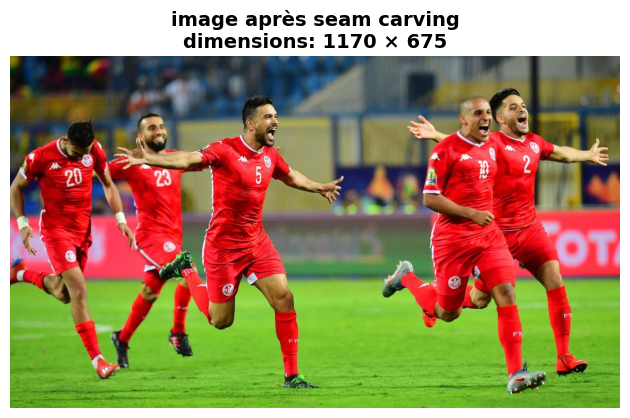

In [18]:
plt.imshow(final_image)
plt.title(f'image après seam carving\ndimensions: {final_image.shape[1]} × {final_image.shape[0]}',fontsize=14,fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


In [19]:
print(f"largeur originale: {test_image.shape[1]} pixels")
print(f"largeur finale: {final_image.shape[1]} pixels")
print(f"réduction: {test_image.shape[1] - final_image.shape[1]} pixels ({((test_image.shape[1] - final_image.shape[1]) / test_image.shape[1] * 100):.1f}%)")

largeur originale: 1200 pixels
largeur finale: 1170 pixels
réduction: 30 pixels (2.5%)
